# <FONT COLOR='#0E6655'><B><CENTER>BREAST CANCER PREDICTION </CENTER></B></FONT>

## <font color='blue'> Table of Contents </font>

- [1 - Objectives](#1)
- [2 - Modules](#2)
- [3 - Helper Functions](#3)
- [4 - Loading and Exploring Data](#4)
- [5 - Preprocessing](#5)
- [6 - Model Selection](#6)
- [7 - Hyperparameter Tuning](#7)

<a name="1"></a>
## <b> <font color='green'> 1. Objectives </b> </font>

Predict the probability of cancer being malignant or benign given a set of features.

<a name="2"></a>
## <b> <font color='green'> 2. Modules </b> </font>

In [60]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential
from keras.layers.core import Dense, Dropout

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.neighbors")

<a name="3"></a>
## <b> <font color='green'> 3. Helper Functions </b> </font>

In [61]:
# add results
def add_results(results, name, accuracy, precision, recall, f1_score):
    """
    Add results to a list
    """
    # if the name is already there, update
    for r in results:
        if r['name'] == name:
            r.update({'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score})
            break
    else:
        results.append({'name': name, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score})
    return results


# plotting functions
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# imprimir para las predicciones dadas por el modelo en particular
def confusion_matrix_per_model(y_test,y_pred):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred )
    np.set_printoptions(precision=2)
    print (classification_report(y_test, y_pred))
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['Benign','Malignant'],normalize= False,title='cm')



<a name="4"></a>
## <b> <font color='green'> 4. Loading and exploring data </b> </font>

In [62]:
df = pd.read_csv('data/data.csv',encoding='utf-8')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [63]:
df.shape

(569, 33)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

<a name="class_balance"></a>
### Class balance

In [65]:
# Count the quantity of 'M' (malignant)
count_malignant = df[df['diagnosis'] == 'M'].shape[0]

# Count the quantity of 'B' (benign)
count_benign = df[df['diagnosis'] == 'B'].shape[0]

print("Quantity of 'M' (malignant):", count_malignant)
print("Quantity of 'B' (benign):", count_benign)

Quantity of 'M' (malignant): 212
Quantity of 'B' (benign): 357


We have a certain imbalance between the classes.

<a name="5"></a>
## <b> <font color='green'> 5. Preprocessing </b> </font>

There is a column named 'Unnamed', it doesn't make much sense to have it, we remove it

In [66]:
df = df.drop('Unnamed: 32', axis=1)

### Missing values

In [67]:
# let's see if there are missing values
df.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

There are no missing values in this dataset, so we won't have to worry about dealing with them. However, if there were any, we have different options to handle them:

- Delete the rows with those values (e.g., `df.dropna(axis=0)`)

- Delete the columns with those values (e.g., `df.dropna(axis=1)`)

- Replace the missing values, for example with the mean (`df.fillna(df.mean())`) or using some estimator.


### Separating features from label

Our label is "diagnosis".


In [68]:
X = df.iloc[:, 2:]
y = df.iloc[:, 1]

In [69]:
X.head(3)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [70]:
y.head(3)

0    M
1    M
2    M
Name: diagnosis, dtype: object

### Dealing with categorical features

We must distinguish between features:

- Ordinal: There is an order (e.g., shirt sizes).
- Nominal: There is no order (e.g., colors).

In this problem, we only need to encode the labels, as the rest of the features are already numeric.

In [71]:
label_encoder_y = LabelEncoder()
y = label_encoder_y.fit_transform(y)
y[:25]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1])

It can be appreciated that now we no longer have M and B but 1 and 0.

In [72]:
# classes
label_encoder_y.classes_

array(['B', 'M'], dtype=object)

### Train/test split

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

len(X_train), len(X_test), len(y_train), len(y_test)

(398, 171, 398, 171)

In [74]:
### Standarize numerical features

sc = StandardScaler()

X_train = sc.fit_transform(X_train) # fit and transform
X_test = sc.transform(X_test) # only transform

<a name="6"></a>
## <b> <font color='green'> 6. Model Selection </b> </font>

This is a supervised classification problem.

We will then try the following models:

- Logistic Regression
- SVM
- Decision Trees
- KNN


Previously, we will initialize a list that will serve us to keep track of the results obtained with each one.


In [75]:
results = []

<a name="6.1"> </a>
### 6.1. Logistic Regression

In [76]:
# Initialize Logistic Regression model
lr = LogisticRegression(solver='liblinear') #random_state=0

# Fit the model
lr.fit(X_train, y_train)

# Make predictions
y_pred_LR = lr.predict(X_test)

# Calculate accuracy
accuracy_LR = accuracy_score(y_test, y_pred_LR)

# Calculate precision, recall, and F1-score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
precision_LR, recall_LR, f1_LR, _ = precision_recall_fscore_support(y_test, y_pred_LR, average='weighted') 
            # weighted takes label imbalanced into account



In [77]:
%%capture

# add results
add_results(results, 'Logistic Regression', accuracy_LR, precision_LR, recall_LR, f1_LR)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       108
           1       0.98      0.95      0.97        63

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171

Confusion matrix, without normalization
[[107   1]
 [  3  60]]


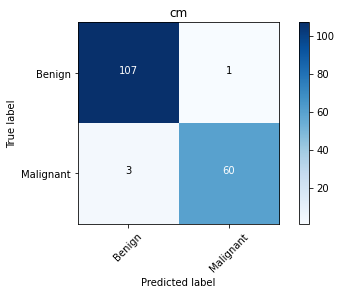

In [78]:
# confussion matrix
confusion_matrix_per_model(y_test,y_pred_LR)

<a name="6.2"> </a>
### 6.2. SVM

In [79]:
# classifier
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, y_train)

# predictions
y_pred_SVM = classifier.predict(X_test)

# accuracy
accuracy_SVM = accuracy_score(y_test, y_pred_SVM)

# precison, recall and f1-score
precision_SVM, recall_SVM, f1_SVM, _ = precision_recall_fscore_support(y_test, y_pred_SVM, average='weighted') 


In [80]:
%%capture

# add results
add_results(results, 'SVM', accuracy_SVM, precision_SVM, recall_SVM, f1_SVM)

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       108
           1       0.92      0.97      0.95        63

    accuracy                           0.96       171
   macro avg       0.95      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171

Confusion matrix, without normalization
[[103   5]
 [  2  61]]


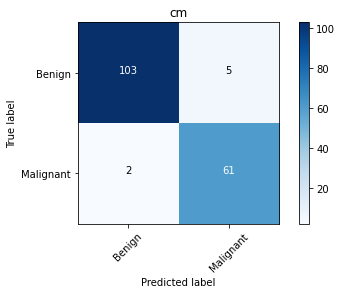

In [81]:
confusion_matrix_per_model(y_test,y_pred_SVM)

<a name="6.3"> </a>
### 6.3. K-NN

Let's try with different values of k. Normally (to find the best k),  we would do this by applying cross-validation using tools like GridSearchCV, but here we will try "manually". Our goal will be accuracy.


In [82]:
[best_k, best_acc] = [0,0.0]

for k in range(4,7):
    # train model
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
    # predict
    y_pred_KNN = neigh.predict(X_test)
    # medimos la precisión
    accuracy_KNN = accuracy_score(y_test, y_pred_KNN)
    if accuracy_KNN > best_acc:
        [k,best_acc] = [k,accuracy_KNN] 
        

print(f"The best accuracy in the tested range was achieved for k = {k}")

The best accuracy in the tested range was achieved for k = 6


In [83]:
#
classifier = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)

# realizamos las predicciones
y_pred_KNN = classifier.predict(X_test)

# medimos la precisión
accuracy_KNN = accuracy_score(y_test, y_pred_KNN)

# Calculate precision, recall, and F1-score
precision_KNN, recall_KNN, f1_KNN, _ = precision_recall_fscore_support(y_test, y_pred_KNN, average='weighted') 


In [84]:
%%capture

# add results
add_results(results, 'K-NN', accuracy_KNN, precision_KNN, recall_KNN, f1_KNN)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       108
           1       0.98      0.90      0.94        63

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171

Confusion matrix, without normalization
[[107   1]
 [  6  57]]


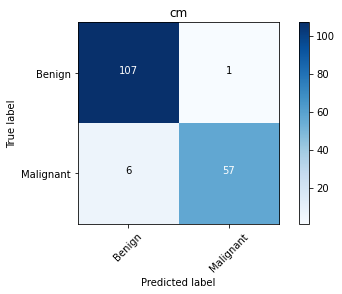

In [85]:
confusion_matrix_per_model(y_test,y_pred_KNN)

<a name="6.4"> </a>
### 6.4. Decision Tree

In this case, normalization is not necessary, but since it also does not affect the performance significantly to have done it, we will continue with the datasets we already have.

<b> Note. </b> In a real-world scenario, we should verify the previous sentence.


In [86]:
tree_classifier = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

tree_classifier.fit(X_train,y_train)

y_pred_tree = classifier.predict(X_test)

accuracy_tree = accuracy_score(y_test, y_pred_tree)

precision_tree, recall_tree, f1_tree, _ = precision_recall_fscore_support(y_test, y_pred_tree, average='weighted') 


In [87]:
%%capture

# add results
add_results(results, 'Decision Tree', accuracy_tree, precision_tree, recall_tree, f1_tree)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       108
           1       0.98      0.90      0.94        63

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171

Confusion matrix, without normalization
[[107   1]
 [  6  57]]


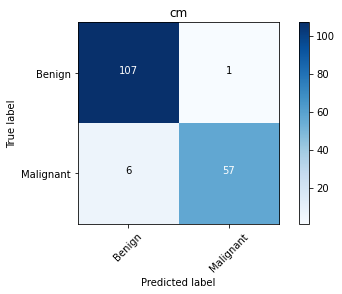

In [88]:
confusion_matrix_per_model(y_test,y_pred_tree)

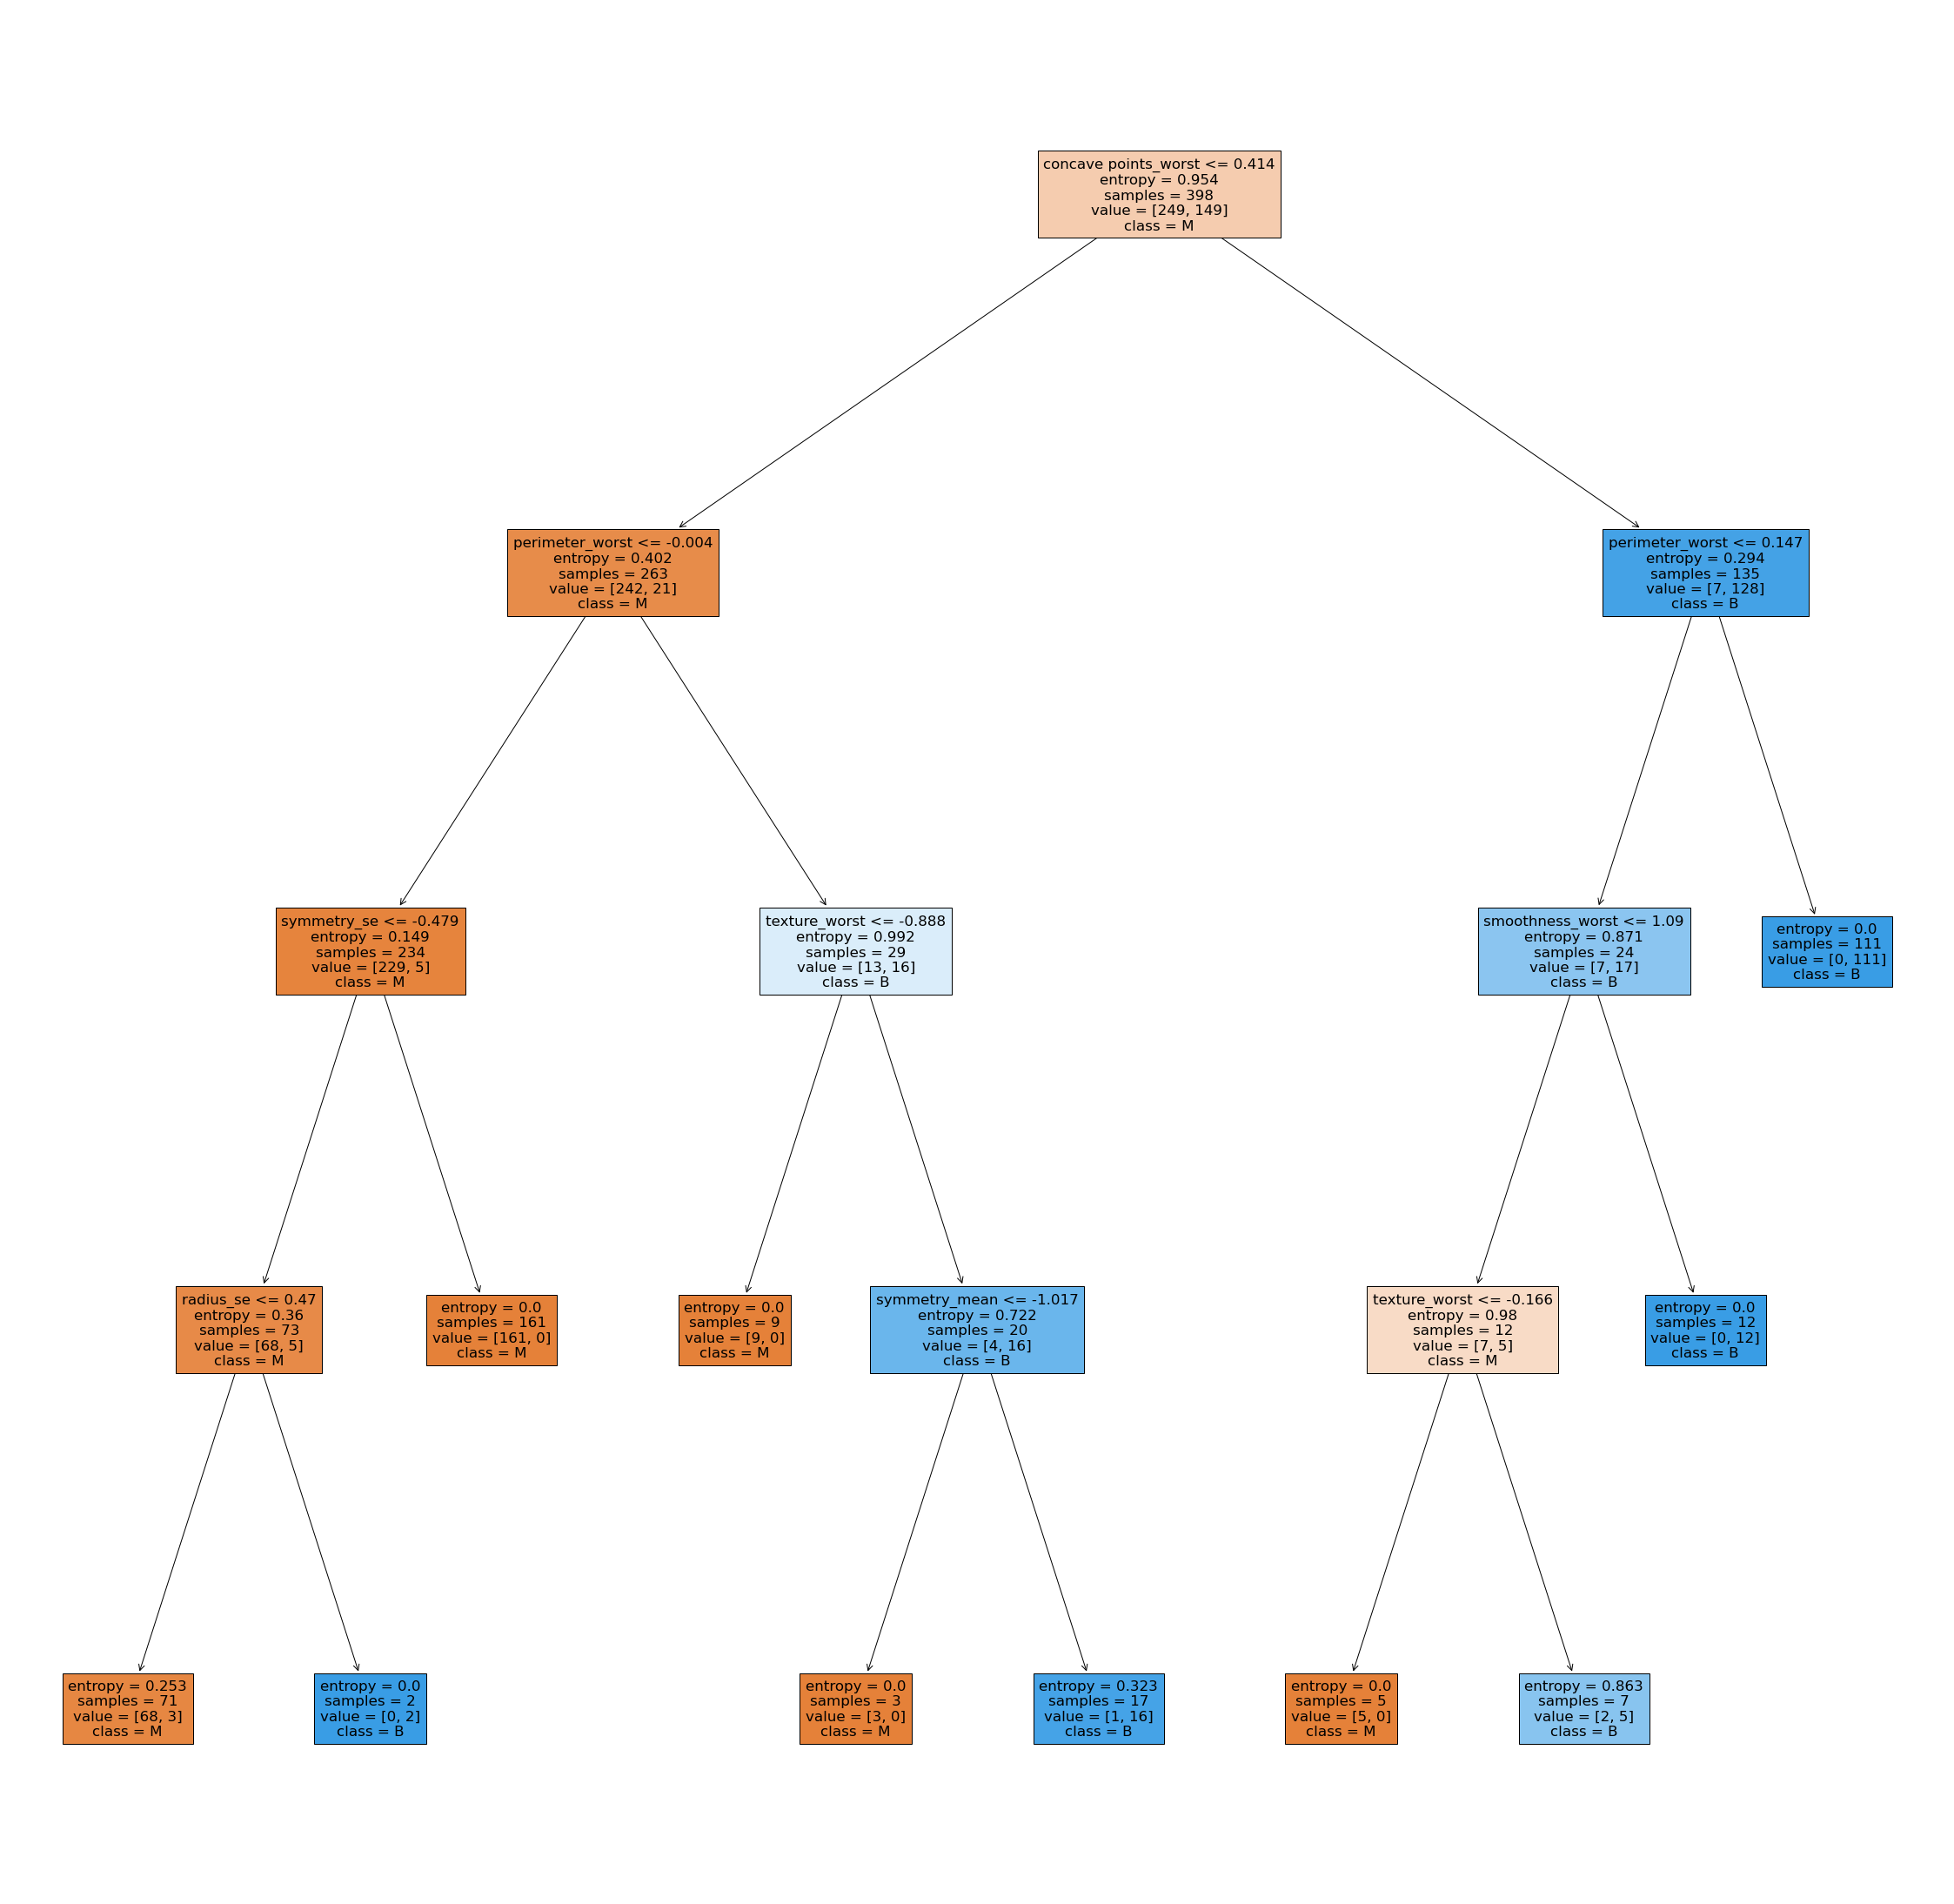

In [89]:
_, ax = plt.subplots(figsize=(40,40)) # Resize figure


tree_graph = plot_tree(tree_classifier,
                        feature_names=X.columns,
                        class_names=['M','B'],
                        ax=ax,
                        filled=True)

<a name="6.5"> </a>
### 6.5. Random Forest

In [90]:
# Initialize a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# precision, recall and f1-score
precision_rf, recall_rf, f1_rf, _ = precision_recall_fscore_support(y_test, y_pred_rf, average='weighted') 


In [91]:
%%capture

# add results
add_results(results, 'Random Forest', accuracy_rf, precision_rf, recall_rf, f1_rf)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       108
           1       0.95      0.95      0.95        63

    accuracy                           0.96       171
   macro avg       0.96      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171

Confusion matrix, without normalization
[[105   3]
 [  3  60]]


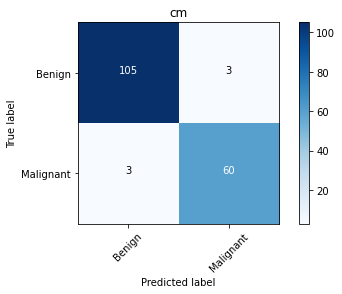

In [92]:
confusion_matrix_per_model(y_test,y_pred_rf)

<a name="6.6"> </a>
### 6.6. Neural Network

We are going to train a very simple neural network.

In [93]:
def build_model(input_dim):
    model = Sequential()
    model.add(Dense(16, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(16, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [94]:
# Define custom metrics functions for precision, recall, and F1 score
def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(tf.round(y_pred), 1)), tf.float32))
    false_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 0), tf.equal(tf.round(y_pred), 1)), tf.float32))
    return true_positives / (true_positives + false_positives + tf.keras.backend.epsilon())

def recall(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(tf.round(y_pred), 1)), tf.float32))
    false_negatives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(tf.round(y_pred), 0)), tf.float32))
    return true_positives / (true_positives + false_negatives + tf.keras.backend.epsilon())

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * (p * r) / (p + r + tf.keras.backend.epsilon())

In [95]:
model = build_model(X_train.shape[1])
 
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy',precision, recall, f1_score])

In [96]:
model.fit(X_train, y_train, epochs=30, verbose=0)

In [97]:
scores = model.evaluate(X_test, y_test)

6/6 [==============================] - 1s 6ms/step - loss: 0.0718 - accuracy: 0.9766 - precision: 0.9744 - recall: 0.9630 - f1_score: 0.9653


In [98]:
%%capture

add_results(results, 'Neural Network', scores[1], scores[2], scores[3], scores[4])

<a name="6.7"> </a>
### 6.7. Choosing the best model

In [99]:
results_df = pd.DataFrame(results)
results_df

,name,accuracy,precision,recall,f1_score
0,Logistic Regression,0.976608,0.976735,0.976608,0.976527
1,SVM,0.959064,0.960059,0.959064,0.959252
2,K-NN,0.959064,0.960113,0.959064,0.958682
3,Decision Tree,0.959064,0.960113,0.959064,0.958682
4,Random Forest,0.964912,0.964912,0.964912,0.964912
5,Neural Network,0.976608,0.974359,0.962963,0.965278


Given the importance of correctly detecting malignant cancer cases, it could be argued that the most relevant metric for selecting the best model is recall. We want to minimize false negatives (malignant cancer cases that are not detected), which translates to maximizing the recall of the model. However, specificity is also important to avoid false positives and minimize the number of benign cases misclassified as malignant.

In conclusion, to select the best model in a breast cancer detection problem, a combination of recall and specificity as primary evaluation metrics could be considered. If seeking a single metric for selection, recall (or F1-score if there is class imbalance) may be more relevant due to the clinical importance of correctly detecting malignant cancer cases.

Let's remember that we have an imbalance between classes: [class balance](#class_balance)

The reason for this choice is that the F1 metric is a measure that combines both precision and recall (sensitivity) into a single metric. This means that F1 takes into account both false positives and false negatives, making it more robust in situations of class imbalance.

In class imbalance, it is common for models to have high precision in the majority class but low recall in the minority class. The F1 metric considers this trade-off between precision and recall, making it a more balanced and appropriate choice for evaluating model performance in this scenario.

Therefore, in this particular case, it would be advisable to choose the F1 metric as the primary evaluation metric for assessing the performance of the breast cancer detection model.

Let's obtain the model with the best F1-score.

In [51]:
# Obtener el nombre del modelo con el mejor F1-score
best_model_name = results_df.loc[results_df['f1_score'].idxmax()]['name']
print("The model with the best F1-score is", best_model_name)

The model with the best F1-score is Logistic Regression


In graphic form:

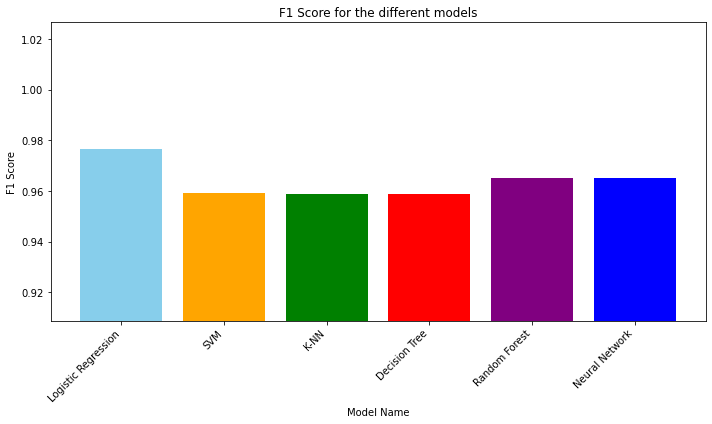

In [105]:
color = ['skyblue', 'orange', 'green', 'red', 'purple', 'blue']


plt.figure(figsize=(10, 6))
plt.bar(results_df['name'], results_df['f1_score'], color=color)
plt.xlabel('Model Name')
plt.ylabel('F1 Score')
plt.title('F1 Score for the different models')
plt.xticks(rotation=45, ha='right')
plt.ylim(min(results_df['f1_score']) - 0.05, max(results_df['f1_score']) + 0.05)  # Establecer límites y agregar un margen
plt.tight_layout()
plt.show()

<a name="7"></a>
## <b> <font color='green'> 7. Hyperparameter Tuning </b> </font>

The model is logistic regression, the hyperparameters we will adjust are:

- C
    - Inverse of regularization strength.

- penalty
    - Norm of the penalty

To find the best values we will use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)



In [106]:
# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1','l2']
}

# Initialize Logistic Regression classifier
lr_classifier = LogisticRegression(solver='liblinear') 

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lr_classifier, param_grid=param_grid, cv=5)

# Fit the GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'C': 1, 'penalty': 'l2'}


In [107]:
# Make predictions with the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9766081871345029


In [108]:
precision_LR, recall_LR, f1_LR, _ = precision_recall_fscore_support(y_test, y_pred_LR, average='weighted')
f1_LR

0.9765268453762402

We did not have differences with the previous model, since in the range tested, the values coincide with the default values (C = 1.0 and penalty = l2)